In [1]:
from data.unaligned_dataset import UnAlignedDataset
import numpy as np
from PIL import Image

In [2]:
dset = UnAlignedDataset("dataset/")

torch.Size([3, 128, 512]) torch.Size([3, 128, 512])


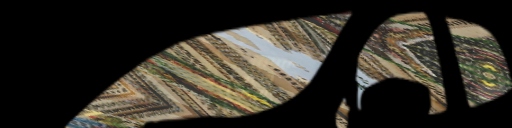

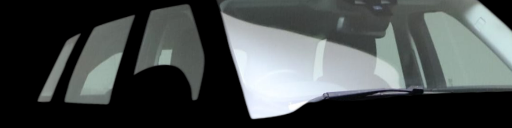

In [3]:
a,b = dset[0]
print(a.shape, b.shape)
display(Image.fromarray(np.uint8(((a+1)*127.5).permute(1,2,0).numpy())))
display(Image.fromarray(np.uint8(((b+1)*127.5).permute(1,2,0).numpy())))

In [1]:
import sagemaker
import boto3
import os
import wandb
from sagemaker.pytorch import PyTorch

In [2]:
try:
    sagemaker_session = sagemaker.Session()
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_permissions')['Role']['Arn']

Couldn't call 'get_role' to get Role ARN from role name Shivam to get Role path.


In [3]:
from datetime import datetime

bucket = "ai-sagemaker-weights"
base_job_name = "seat-gen-unpaired"
checkpoint_suffix = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
checkpoint_s3_path = f"s3://{bucket}/{base_job_name}-{checkpoint_suffix}"
# checkpoint_s3_path = "s3://ai-sagemaker-weights/seat-gen-unpaired-2022-09-06-14-13-41"
print(checkpoint_s3_path)

s3://ai-sagemaker-weights/seat-gen-unpaired-2022-09-09-13-47-08


In [4]:
source_dir = os.getcwd()
wandb.sagemaker_auth(path=source_dir)

estimator = PyTorch(entry_point='sage_train.sh',
                    source_dir=source_dir,
                    role=role,
                    py_version='py38',
                    framework_version='1.12.0',
                    base_job_name=base_job_name,
                    checkpoint_s3_uri=checkpoint_s3_path,
#                     input_mode='FastFile',
                    instance_count=1,
                    instance_type='ml.g5.2xlarge',
                    use_spot_instances=True,  # Use a spot instance
                    max_run=2*24*60*60,  # Max training time
                    max_wait=2*24*60*60,  # Max training time + spot waiting time seconds
                    hyperparameters={
                        "encoder": "seresnet18",
                        "n_epochs": 100,
                        "n_epochs_decay": 100,
                        "batch_size": 8,
                        "lr": 0.0002,
                        "ngf": 64,
                        "ndf": 64,
                        "n_layers_D": 3,
                        "project": "new_cut",
                        "use_wandb": True,
                        "name": "no_windows/",
                    })

In [ ]:
estimator.fit({'train': 's3://ai-sagemaker-datasets/seat_gen_unpaired_new/'}, wait=True)